## episcanpy

In [2]:
import episcanpy.api as epi
import anndata as ad 
import matplotlib as mpt
import numpy as np
import pandas as pd
import pyliftover
import pysam
import scanpy as sc
import scipy as sp
import sklearn as sk
import seaborn as sn

In [3]:
#from Xi's pipeline
from glob import iglob
import matplotlib as mpl
from scipy.io import mmread
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.preprocessing import scale
from sklearn.decomposition import TruncatedSVD
from sklearn.cluster import SpectralClustering
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfTransformer

## Loading the filtered matrix from 10x

In [4]:
matrix = '/mnt/basespace/01_scATAC_F74_count_01/outs/filtered_peak_bc_matrix/matrix.mtx'
cell_names = '/mnt/basespace/01_scATAC_F74_count_01/outs/filtered_peak_bc_matrix/barcodes.tsv'
var_names = '/mnt/basespace/01_scATAC_F74_count_01/outs/peaks.bed'

In [75]:
type(var_names)

str

In [77]:
type(cell_names)

str

In [78]:
type(matrix)

list

In [5]:
adata = epi.pp.read_ATAC_10x(matrix, cell_names, var_names)

In [7]:
adata

AnnData object with n_obs × n_vars = 7674 × 109350 
    uns: 'omic'

In [8]:
adata.shape

(7674, 109350)

In [7]:
adata.X

matrix([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [8]:
# read HOMER annotation to get the nearest gene associated with each peak

homer = pd.read_table('/mnt/basespace/01_scATAC_F74_count_01/F74_annotated_peaks_homer_output.txt',
                      index_col=0)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: FutureWarning: read_table is deprecated, use read_csv instead, passing sep='\t'.
  after removing the cwd from sys.path.


In [11]:
homer.columns

Index(['Chr', 'Start', 'End', 'Strand', 'Peak Score',
       'Focus Ratio/Region Size', 'Annotation', 'Detailed Annotation',
       'Distance to TSS', 'Nearest PromoterID', 'Entrez ID', 'Nearest Unigene',
       'Nearest Refseq', 'Nearest Ensembl', 'Gene Name', 'Gene Alias',
       'Gene Description', 'Gene Type'],
      dtype='object')

### Generate a column merging the columns chr, start and end

In [9]:
homer['ChrStartEnd']=homer['Chr'].astype(str)+'_'+homer['Start'].astype(str)+'_'+homer['End'].astype(str)

### reindexing homer to match the index of adata.var

In [10]:
homer.head(5)

,Chr,Start,End,Strand,Peak Score,Focus Ratio/Region Size,Annotation,Detailed Annotation,Distance to TSS,Nearest PromoterID,Entrez ID,Nearest Unigene,Nearest Refseq,Nearest Ensembl,Gene Name,Gene Alias,Gene Description,Gene Type,ChrStartEnd
PeakID (cmd=annotatePeaks.pl peaks_homer_input_3.txt hg19),,,,,,,,,,,,,,,,,,,
16199,chr2,170970014,170970337,+,NaN,0,Intergenic,HERVK22-int|LTR|ERVK,-64480,NM_138995,140469.0,Hs.671900,NM_138995,ENSG00000071909,MYO3B,-,myosin IIIB,protein-coding,chr2_170970014_170970337
62212,chr10,98170450,98170929,+,NaN,0,"intron (NM_012465, intron 8 of 20)","intron (NM_012465, intron 8 of 20)",-51567,NM_033207,93377.0,Hs.12449,NM_033207,ENSG00000197430,OPALIN,HTMP10|TMEM10|TMP10,oligodendrocytic myelin paranodal and inner lo...,protein-coding,chr10_98170450_98170929
28301,chr4,67895895,67896295,+,NaN,0,Intergenic,MER33|DNA|hAT-Charlie,391623,NR_110747,101927237.0,Hs.435644,NR_110747,ENSG00000250075,LOC101927237,-,uncharacterized LOC101927237,ncRNA,chr4_67895895_67896295
33844,chr5,94815259,94815954,+,NaN,0,"intron (NM_014639, intron 39 of 42)",L1ME3|LINE|L1,75103,NM_014639,9652.0,Hs.482868,NM_014639,ENSG00000198677,TTC37,KIAA0372|Ski3|THES,tetratricopeptide repeat domain 37,protein-coding,chr5_94815259_94815954
89191,chr17,16434665,16435710,+,NaN,0,Intergenic,AluSx|SINE|Alu,37339,NM_020653,57336.0,Hs.99724,NM_020653,ENSG00000141040,ZNF287,ZKSCAN13|ZSCAN45,zinc finger protein 287,protein-coding,chr17_16434665_16435710


In [11]:
a = pd.concat([adata.var, homer], axis=1)
a.head(2)

,Chr,Start,End,Strand,Peak Score,Focus Ratio/Region Size,Annotation,Detailed Annotation,Distance to TSS,Nearest PromoterID,Entrez ID,Nearest Unigene,Nearest Refseq,Nearest Ensembl,Gene Name,Gene Alias,Gene Description,Gene Type,ChrStartEnd
1,chr1,191288.0,191962.0,+,NaN,0.0,Intergenic,Intergenic,-51059.0,NR_039983,729737.0,Hs.534942,NR_039983,NaN,LOC729737,-,uncharacterized LOC729737,ncRNA,chr1_191288_191962
2,chr1,267777.0,268251.0,+,NaN,0.0,Intergenic,Intergenic,-55878.0,NR_028322,100132287.0,Hs.446409,NR_028322,NaN,LOC100132287,-,uncharacterized LOC100132287,ncRNA,chr1_267777_268251


In [145]:
for x in (a.columns):
          adata.var[x] = a[x]

In [13]:
adata.var = pd.merge(adata.var, a, left_index=True, right_on='ChrStartEnd')

AnnData expects string indices for some functionality, but your first two indices are: Index([1, 2], dtype='object'). 


In [84]:
adata.var = adata.var.set_index(adata.var['Gene Name'])

In [107]:
pd.DataFrame.set_index??

Signature:
pd.DataFrame.set_index(
    self,
    keys,
    drop=True,
    append=False,
    inplace=False,
    verify_integrity=False,
)
Source:   
    def set_index(self, keys, drop=True, append=False, inplace=False,
                  verify_integrity=False):
        """
        Set the DataFrame index using existing columns.

        Set the DataFrame index (row labels) using one or more existing
        columns or arrays (of the correct length). The index can replace the
        existing index or expand on it.

        Parameters
        ----------
        keys : label or array-like or list of labels/arrays
            This parameter can be either a single column key, a single array of
            the same length as the calling DataFrame, or a list containing an
            arbitrary combination of column keys and arrays. Here, "array"
            encompasses :class:`Series`, :class:`Index` and ``np.ndarray``.
        drop : bool, default True
            Delete columns to be used a

In [85]:
adata.var

,Chr,Start,End,Strand,Peak Score,Focus Ratio/Region Size,Annotation,Detailed Annotation,Distance to TSS,Nearest PromoterID,Entrez ID,Nearest Unigene,Nearest Refseq,Nearest Ensembl,Gene Name,Gene Alias,Gene Description,Gene Type,ChrStartEnd,commonness
Gene Name,,,,,,,,,,,,,,,,,,,,
LOC729737,chr1,191288.0,191962.0,+,NaN,0.0,Intergenic,Intergenic,-51059.0,NR_039983,729737.0,Hs.534942,NR_039983,nan,LOC729737,-,uncharacterized LOC729737,ncRNA,chr1_191288_191962,209.0
LOC100132287,chr1,267777.0,268251.0,+,NaN,0.0,Intergenic,Intergenic,-55878.0,NR_028322,100132287.0,Hs.446409,NR_028322,nan,LOC100132287,-,uncharacterized LOC100132287,ncRNA,chr1_267777_268251,166.0
nan,chr1,586033.0,586326.0,+,NaN,0.0,Intergenic,L3|LINE|CR1,-18386.0,NR_106781,NaN,nan,nan,nan,nan,nan,nan,nan,chr1_586033_586326,76.0
OR4F29,chr1,629714.0,630201.0,+,NaN,0.0,Intergenic,Intergenic,-7923.0,NM_001005221,729759.0,Hs.632360,NM_001005221,ENSG00000284733,OR4F29,OR7-21,olfactory receptor family 4 subfamily F member 29,protein-coding,chr1_629714_630201,329.0
OR4F29,chr1,633750.0,634305.0,+,NaN,0.0,Intergenic,THE1B|LTR|ERVL-MaLR,-11993.0,NM_001005221,729759.0,Hs.632360,NM_001005221,ENSG00000284733,OR4F29,OR7-21,olfactory receptor family 4 subfamily F member 29,protein-coding,chr1_633750_634305,1323.0
LINC01128,chr1,778184.0,779461.0,+,NaN,0.0,"non-coding (NR_047526, exon 3 of 3)","non-coding (NR_047526, exon 3 of 3)",15644.0,NR_047525,643837.0,Hs.133183,NR_015368,ENSG00000228794,LINC01128,-,long intergenic non-protein coding RNA 1128,ncRNA,chr1_778184_779461,1795.0
FAM41C,chr1,826706.0,827979.0,+,NaN,0.0,Intergenic,AluSp|SINE|Alu,-15160.0,NR_027055,284593.0,Hs.449006,NR_027055,ENSG00000230368,FAM41C,-,family with sequence similarity 41 member C,ncRNA,chr1_826706_827979,1332.0
LOC100130417,chr1,837658.0,838716.0,+,NaN,0.0,Intergenic,Intergenic,16885.0,NR_026874,100130417.0,Hs.200644,NM_175912,ENSG00000223764,LOC100130417,-,uncharacterized LOC100130417,ncRNA,chr1_837658_838716,348.0
LOC100130417,chr1,841550.0,843143.0,+,NaN,0.0,Intergenic,Intergenic,12726.0,NR_026874,100130417.0,Hs.200644,NM_175912,ENSG00000223764,LOC100130417,-,uncharacterized LOC100130417,ncRNA,chr1_841550_843143,484.0


In [148]:
type(homer)

pandas.core.frame.DataFrame

In [151]:
homer.shape

(109350, 19)

In [77]:
homer.count()

Chr                        109350
Start                      109350
End                        109350
Strand                     109350
Peak Score                      0
Focus Ratio/Region Size    109350
Annotation                 109350
Detailed Annotation        109350
Distance to TSS            109350
Nearest PromoterID         109350
Entrez ID                  109143
Nearest Unigene            100781
Nearest Refseq             109143
Nearest Ensembl            100521
Gene Name                  109143
Gene Alias                 109143
Gene Description           109143
Gene Type                  109143
ChrStartEnd                109350
dtype: int64

In [89]:
a.count()

Chr                        109350
Start                      109350
End                        109350
Strand                     109350
Peak Score                      0
Focus Ratio/Region Size    109350
Annotation                 109350
Detailed Annotation        109350
Distance to TSS            109350
Nearest PromoterID         109350
Entrez ID                  109143
Nearest Unigene            100781
Nearest Refseq             109143
Nearest Ensembl            100521
Gene Name                  109143
Gene Alias                 109143
Gene Description           109143
Gene Type                  109143
ChrStartEnd                109350
dtype: int64

## Quality control

In [18]:
epi.pp.commoness_features??

Signature: epi.pp.commoness_features(adata, threshold=None, bw=0.5, key_added=None)
Source:   
def commoness_features(adata, threshold=None, bw=0.5, key_added=None):
    """
    Display how often a feature is measured as open (for ATAC-seq).
    Distribution of the feature commoness in cells.
    """
    if key_added == None:
        key_added='commonness'
    
    adata_tmp = adata.copy()
    adata_tmp = adata_tmp.transpose()
    common = []
    matrix = np.matrix(adata_tmp.X)
    matrix = matrix.transpose()
    matrix = matrix.tolist()
    for var in matrix:
        common.append(sum(var))
    adata.var[key_added] = common

    if threshold != None:
        plt.axvline(x=threshold, color='r')
    bw_param = bw
    sns.set_style('whitegrid')
    sns.kdeplot(np.array(adata.var[key_added]), bw=bw_param)
File:      ~/.local/lib/python3.6/site-packages/episcanpy/preprocessing/_quality_control.py
Type:      function


In [29]:
adata_tmp = adata.copy()

In [30]:
adata_tmp = adata_tmp.transpose()

In [31]:
common = []

In [32]:
matrix = np.matrix(adata_tmp.X)

In [33]:
matrix = matrix.tolist()

In [34]:
for var in matrix:
    common.append(sum(var))

In [35]:
key_added='commonness'

In [36]:
adata.var[key_added] = common

In [37]:
adata.var.shape

(109350, 20)

In [38]:
len(common)

109350

In [39]:
threshold=None

In [40]:
bw=0.5

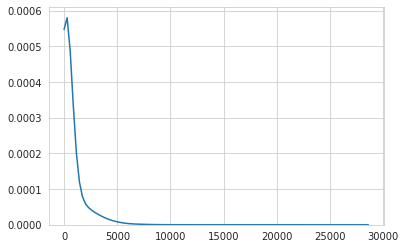

In [41]:
if threshold != None:
        plt.axvline(x=threshold, color='r')
bw_param = bw
sn.set_style('whitegrid')
sn.kdeplot(np.array(adata.var[key_added]), bw=bw_param)

#### create adatabin (binarized matrix)

In [42]:
# create another adata object with binarised matrix
adatabin = epi.pp.binarize(adata, copy=True)

#### adatabin commoness

In [43]:
adatabin_tmp = adatabin.copy()

In [44]:
adatabin_tmp = adatabin_tmp.transpose()

In [45]:
common = []

In [46]:
matrix = np.matrix(adatabin_tmp.X)

In [47]:
matrix = matrix.tolist()

In [48]:
for var in matrix:
    common.append(sum(var))

In [49]:
adatabin.var[key_added] = common

In [50]:
adatabin.var.shape

(109350, 20)

In [51]:
len(common)

109350

In [52]:
threshold=None

In [53]:
bw=0.5

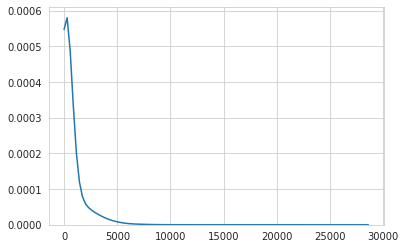

In [54]:
if threshold != None:
        plt.axvline(x=threshold, color='r')
bw_param = bw
sn.set_style('whitegrid')
sn.kdeplot(np.array(adata.var[key_added]), bw=bw_param)

In [55]:
adatabin.shape

(7674, 109350)

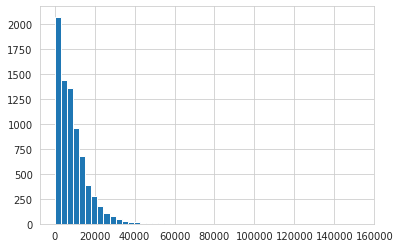

In [56]:
epi.pp.coverage_cells(adata)

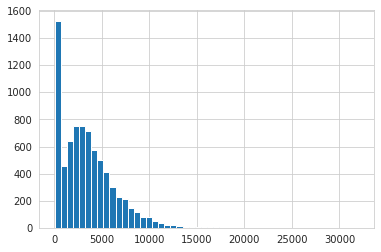

In [57]:
epi.pp.coverage_cells(adatabin)

## Visualisation

### initial matrix

In [58]:
sc.pp.pca(adata)
sc.pp.neighbors(adata)

/home/ubuntu/.local/lib/python3.6/site-packages/umap/umap_.py:349: NumbaWarning: 
Compilation is falling back to object mode WITH looplifting enabled because Function "fuzzy_simplicial_set" failed type inference due to: Untyped global name 'nearest_neighbors': cannot determine Numba type of <class 'function'>

File "../home/ubuntu/.local/lib/python3.6/site-packages/umap/umap_.py", line 467:
def fuzzy_simplicial_set(
    <source elided>
    if knn_indices is None or knn_dists is None:
        knn_indices, knn_dists, _ = nearest_neighbors(
        ^

  @numba.jit()
/home/ubuntu/.local/lib/python3.6/site-packages/numba/compiler.py:725: NumbaWarning: Function "fuzzy_simplicial_set" was compiled in object mode without forceobj=True.

File "../home/ubuntu/.local/lib/python3.6/site-packages/umap/umap_.py", line 350:
@numba.jit()
def fuzzy_simplicial_set(
^

  self.func_ir.loc))
/home/ubuntu/.local/lib/python3.6/site-packages/numba/compiler.py:734: NumbaDeprecationWarning: 
Fall-back from the 

In [59]:
sc.tl.pca(adata)
sc.tl.tsne(adata)
sc.tl.umap(adata)
sc.tl.louvain(adata)

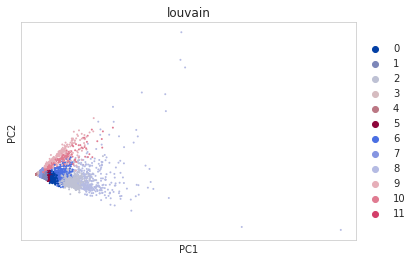

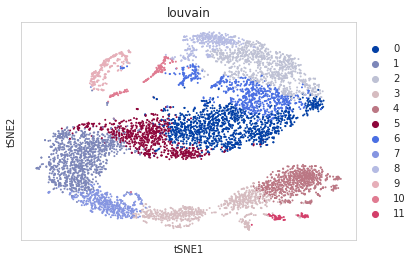

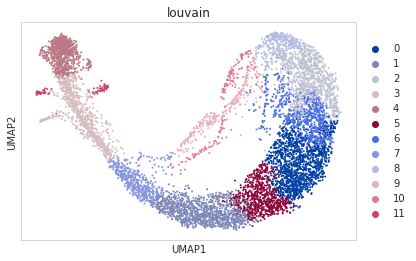

In [60]:
sc.pl.pca(adata, color='louvain')
sc.pl.tsne(adata, color='louvain')
sc.pl.umap(adata, color='louvain')

In [73]:
adata.var_names

Index([     1,      2,      3,      4,      5,      6,      7,      8,      9,
           10,
       ...
       109341, 109342, 109343, 109344, 109345, 109346, 109347, 109348, 109349,
       109350],
      dtype='object', length=109350)

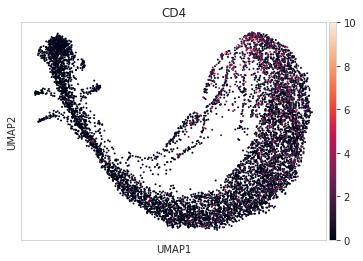

In [87]:
sc.pl.umap(adata, color=['CD4',)

### binary matrix

In [45]:
sc.pp.pca(adatabin)
sc.pp.neighbors(adatabin)
sc.tl.pca(adatabin)
sc.tl.tsne(adatabin)
sc.tl.umap(adatabin)
sc.tl.louvain(adatabin, key_added='louvain_bin')

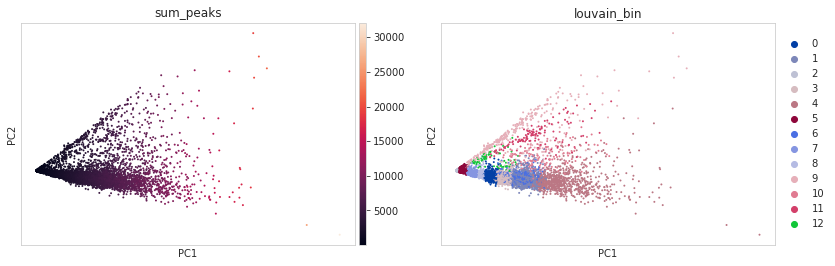

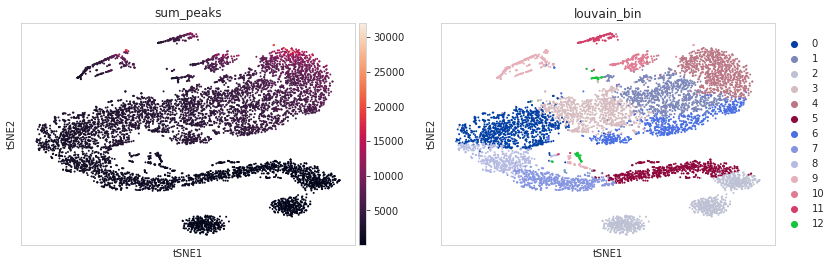

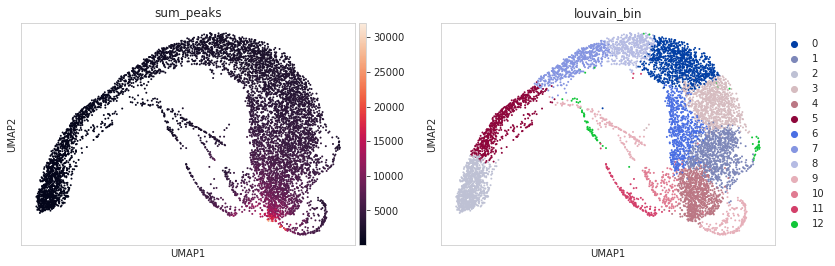

In [46]:
sc.pl.pca(adatabin, color=['sum_peaks', 'louvain_bin'])
sc.pl.tsne(adatabin, color=['sum_peaks', 'louvain_bin'])
sc.pl.umap(adatabin, color=['sum_peaks', 'louvain_bin'])

### do we need to regress or do extra filtering?

In [50]:
# transfer annotations from the binary matrix to the original one
adata.obs['louvain_bin'] = adatabin.obs['louvain_bin'] 
adata.obs['sum_peaks_bin'] = adatabin.obs['sum_peaks']

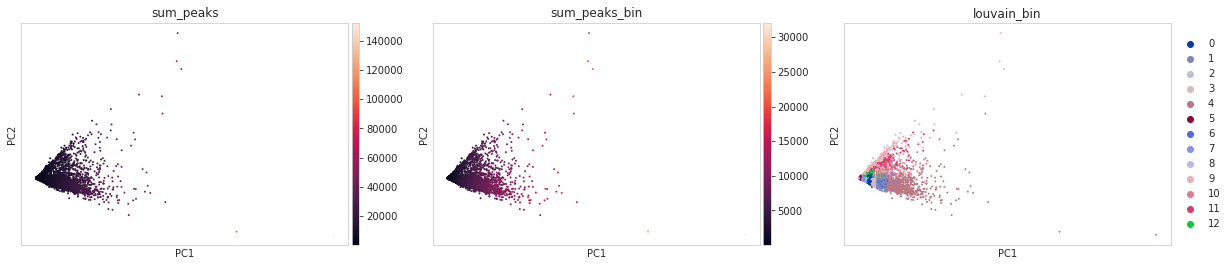

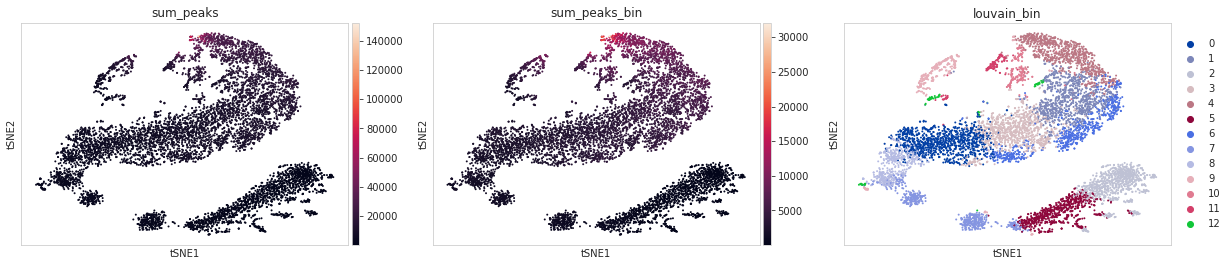

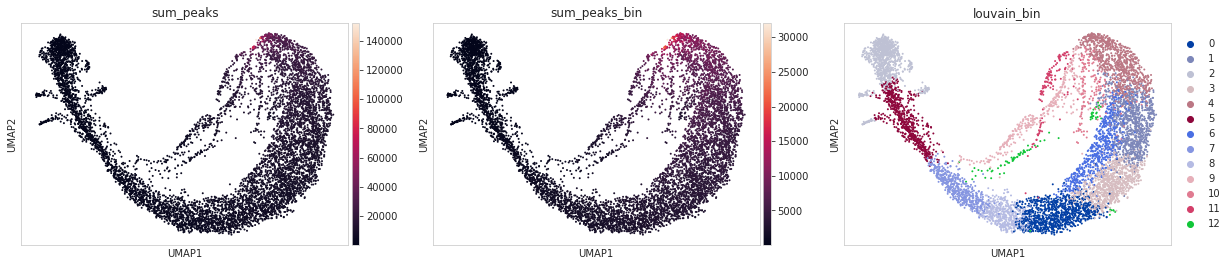

In [51]:
sc.pl.pca(adata, color=['sum_peaks', 'sum_peaks_bin', 'louvain_bin'])
sc.pl.tsne(adata, color=['sum_peaks', 'sum_peaks_bin', 'louvain_bin'])
sc.pl.umap(adata, color=['sum_peaks', 'sum_peaks_bin', 'louvain_bin'])

### filtering out peaks that are not covered enough

In [52]:
min(adatabin.obs['sum_peaks'])

40.0

In [53]:
np.median(adatabin.var['commonness'])

80.0

In [54]:
np.mean(adatabin.var['commonness'])

241.7409967992684

In [55]:
#adatabin400 = adatabin[adatabin.var['commonness'] > 365,:]
adatabin400 = adatabin[:, adatabin.var['commonness'] > 80]

In [56]:
sc.pp.pca(adatabin400)
sc.pp.neighbors(adatabin400)
sc.tl.pca(adatabin400)
sc.tl.tsne(adatabin400)
sc.tl.umap(adatabin400)
sc.tl.louvain(adatabin400, key_added='louvain_bin400')

Trying to set attribute `.obsm` of view, making a copy.


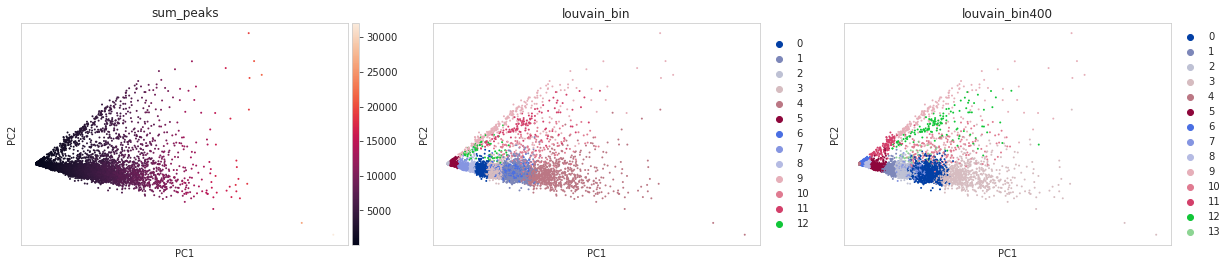

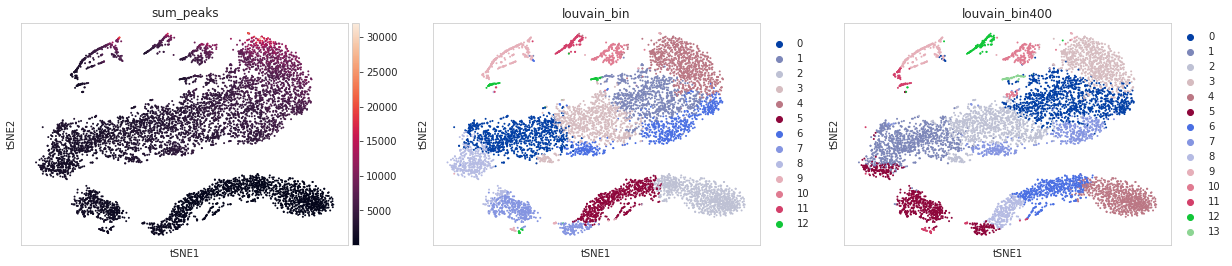

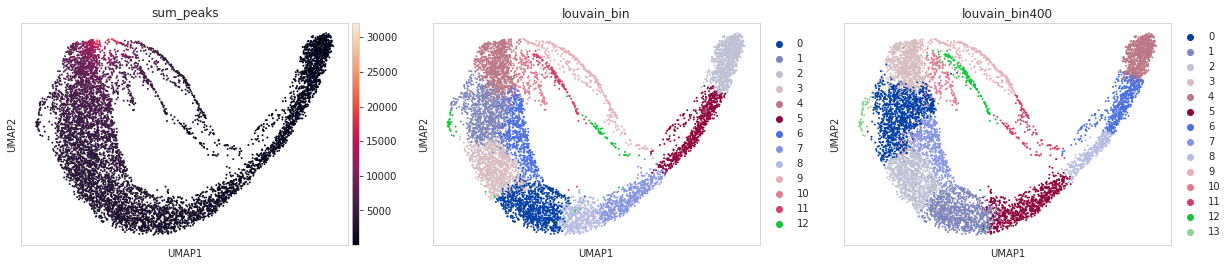

In [57]:
sc.pl.pca(adatabin400, color=['sum_peaks', 'louvain_bin', 'louvain_bin400'])
sc.pl.tsne(adatabin400, color=['sum_peaks', 'louvain_bin', 'louvain_bin400'])
sc.pl.umap(adatabin400, color=['sum_peaks', 'louvain_bin', 'louvain_bin400'])

### regressing the binary matrix based on the number of covered peaks

In [58]:
sc.pp.regress_out(adatabin400, 'sum_peaks')

ImportError: cannot import name 'factorial'

In [ ]:
sc.pp.pca(adatabin400)
sc.pp.neighbors(adatabin400)
sc.tl.pca(adatabin400)
sc.tl.tsne(adatabin400)
sc.tl.umap(adatabin400)
sc.tl.louvain(adatabin400, key_added='louvain_bin400_reg')

In [ ]:
sc.pl.pca(adatabin400, color=['sum_peaks', 'louvain_bin400', 'louvain_bin400_reg'])
sc.pl.tsne(adatabin400, color=['sum_peaks', 'louvain_bin400', 'louvain_bin400_reg'])
sc.pl.umap(adatabin400, color=['sum_peaks', 'louvain_bin400', 'louvain_bin400_reg'])

In [225]:
sc.tl.louvain(adatabin400, resolution=0.2, key_added='louvain_lowres')

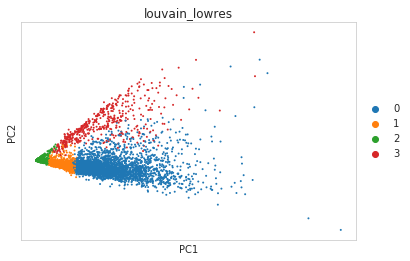

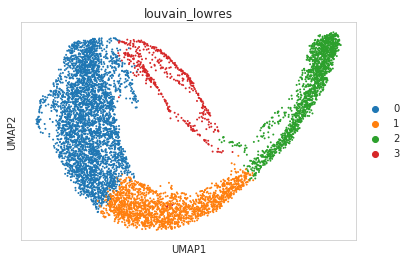

In [226]:
sc.pl.pca(adatabin400, color=['louvain_lowres'])
sc.pl.umap(adatabin400, color=['louvain_lowres'])

In [227]:
sc.tl.diffmap(adatabin400)

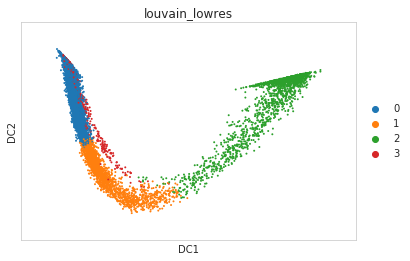

In [228]:
sc.pl.diffmap(adatabin400, color=['louvain_lowres'])

In [82]:
adatabin400.write('peaks_filtered2_bin_10Xdata.h5ad')

In [83]:
adata = sc.read('peaks_filtered2_bin_10Xdata.h5ad')

## Rank features

In [59]:
epi.tl.rank_features(adatabin400, groupby='louvain_bin400', omic='ATAC')

NameError: name 'sc' is not defined

In [60]:
epi.tl.identify_cluster(adatabin400, cell_type=, cell_type_markers=, peak_promoter_file=)

TypeError: identify_cluster() missing 3 required positional arguments: 'cell_type', 'cell_type_markers', and 'peak_promoter_file'

## continuation from Xi's pipeline

In [62]:
mpl.rcParams['axes.titlesize'] = 19
mpl.rcParams['axes.labelsize'] = 16
mpl.rcParams['legend.fontsize'] = 13
mpl.rcParams['legend.markerscale'] = 4
mpl.rcParams['xtick.labelsize'] = 14
mpl.rcParams['ytick.labelsize'] = 14
mpl.rcParams['figure.dpi'] = 100

sn.set_style('ticks')
sn.set_palette('Set1')

In [111]:
# read HOMER annotation to get the nearest gene associated with each peak

homer = pd.read_table('/mnt/basespace/01_scATAC_F74_count_01/outs/F74_annotated_peaks.txt',
                      index_col=0)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: FutureWarning: read_table is deprecated, use read_csv instead, passing sep='\t'.
  after removing the cwd from sys.path.


### Check the counts in peaks around some marker genes

In [65]:
marker_genes = ['CD4','CD8A','CD8B','IFNG','EPCAM','MS4A1','RAG1','RORC','TBX21','CLEC9A']

In [73]:
homer.shape

(109350, 18)

In [74]:
adata.var.shape

(109350, 1)

In [80]:
type(homer)

pandas.core.frame.DataFrame

In [ ]:
gene_reg_sum = p2g_count.groupby('Gene Name').sum()
gene_reg_sum.head(2)

In [ ]:
fig, ax = plt.subplots(figsize=(15, 15), ncols=5, nrows=5)

ax = ax.flatten()

for i,j in enumerate(marker_genes):
    ax[i].scatter(sample_info["t-SNE Dimension 1"], sample_info["t-SNE Dimension 2"],
                  cmap="OrRd", c=gene_reg_sum.loc[j],
                  vmin=0, vmax=10, s=2)
    ax[i].tick_params(left=False, bottom=False)
    ax[i].set_xticks([])
    ax[i].set_yticks([])
    ax[i].set_title(j, fontsize=12)
fig.tight_layout()

### Annotate the clusters

In [ ]:
cluster_annotation = { 0 : 'Granulocyte',
                       1 : 'Follicular_B',
                       2 : 'Memory_CD8_T',
                       3 : 'Naive_CD4_T',
                       4 : 'Marginal_Zone_B',
                       5 : 'Macrophage',
                       6 : 'Naive_CD8_T',
                       7 : 'Transitional_B',
                       8 : 'CD27-_Natural_Killer',
                       9 : 'Regulatory_T',
                      10 : 'Dendritic_cell',
                      11 : 'CD27+_Natural_Killer'}

sample_info['putative_cell_type'] = sample_info.cluster_labels.replace(cluster_annotation)
sample_info.putative_cell_type.value_counts()

In [ ]:
sample_info.head(2)

In [ ]:
# # output sample_info

# sample_info.to_csv('mSp_scATAC-seq/sample_info.csv')

In [ ]:
g = sns.FacetGrid(sample_info, hue='cluster_labels', height=6, palette=sns.color_palette(color12))
g.map(plt.scatter, 't-SNE Dimension 1', 't-SNE Dimension 2', s=2, rasterized=True)
g.ax.legend(bbox_to_anchor=[1.1,0.8], title='Cluster label:', frameon=False)

# lgd = g.ax.get_legend()
# ltt = lgd.get_title()
# ltt.set_fontsize(15)
# # change legend labels from nubmers to cell types
# txt = lgd.get_texts()
# for t in txt:
#     cl = t.get_text()
#     t.set_text(cluster_annotation[int(cl)])

g.ax.text(-45, -30, 'B.Fo', fontsize=10, weight='bold', color=color12[1])

g.ax.text(-5, 75, 'CD27- NK', fontsize=10, weight='bold', color=color12[8])
g.ax.text(25, 63, 'CD27+ NK', fontsize=10, weight='bold', color=color12[11])

g.ax.text(13, -40, 'CD4T Nve', fontsize=10, weight='bold', color=color12[3])
g.ax.text(45, -15, 'Treg', fontsize=10, weight='bold', color=color12[9])

g.ax.text(-50, 29, 'B.MZ', fontsize=10, weight='bold', color=color12[4])
g.ax.text(5, 55, 'GN', fontsize=10, weight='bold', color=color12[0])

g.ax.text(42, 32, 'CD8T Nve', fontsize=10, weight='bold', color=color12[6])
g.ax.text(38, -5, 'CD8T Mem', fontsize=10, weight='bold', color=color12[2])

g.ax.text(-38, 60, 'DC', fontsize=10, weight='bold', color=color12[10])
g.ax.text(-22, 70, 'MF', fontsize=10, weight='bold', color=color12[5])
g.ax.text(-18, 30, 'B.T2', fontsize=10, weight='bold', color=color12[7])

g.ax.spines['top'].set_visible(True)
g.ax.spines['right'].set_visible(True)
g.ax.tick_params(left=False, bottom=False)
g.ax.set_xticks([])
g.ax.set_yticks([])

# plt.savefig('figures/tSNE_colored_by_clustering_annotation.pdf',
#             bbox_inches='tight', transparent=True)

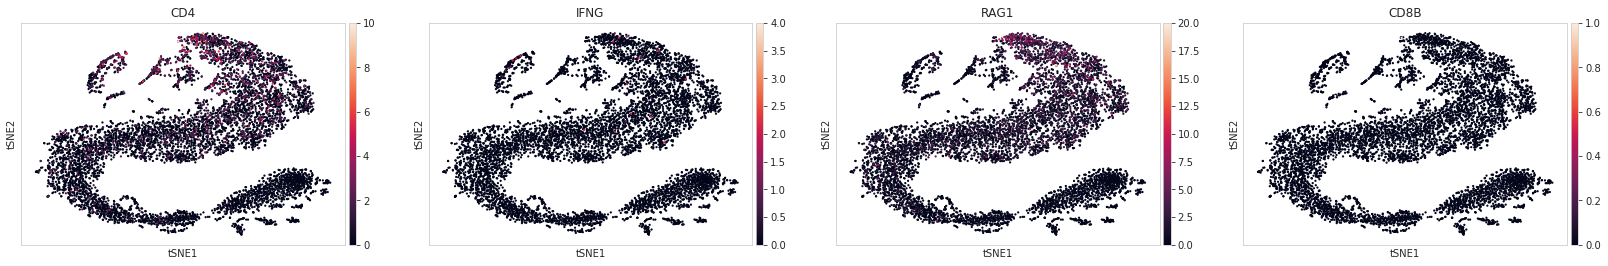

In [96]:
sc.pl.tsne(adata, color=['CD4','IFNG','RAG1','CD8B'], size=20)

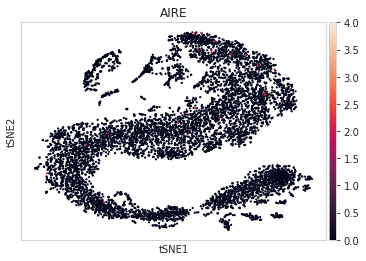

In [97]:
sc.pl.tsne(adata, color=['AIRE'], size=20)

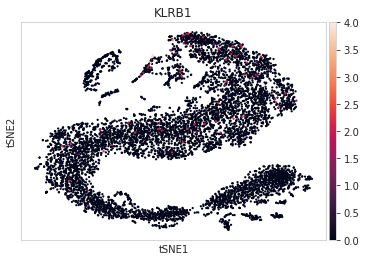

In [101]:
sc.pl.tsne(adata, color=['KLRB1'], size=20)

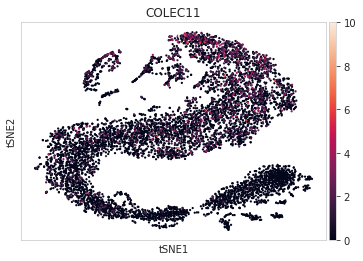

In [102]:
sc.pl.tsne(adata, color=['COLEC11'], size=20)